# Sensitivity-regularized control synthesis

Goal: develop a rapid prototype of a control optimization system that uses a sensitivity-regularized optimization scheme.

Sub-goals:
- Implement a differentiable simulator for a simple continuous control task, taking in design parameters (control gains) and exogenous parameters (disturbances) and returning a cost (distance from goal after some amount of time).
- Implement a wrapper around the differentiable simulator that gets the cost (autodiff'd) and the derivative of that cost w.r.t. the exogenous parameters (also autodiff'd).
- Implement a gradient-based optimization scheme for finding design parameters that robustly optimize the cost.

Additional context: I tried implementing this example in pytorch and got god-awful debugging messages, so I'm trying it in JAX here.

## A Differentiable Simulator

This simulates a simple continuous control task using PyTorch (enabling easy autodiff). The task is to navigate a 2D quadrotor to the origin starting from a given point. There is wind blowing in the -x direction, which applies a lift and drag to the quadrotor (modelled as a flat plate).

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scipy.linalg
from tqdm import tqdm

In [2]:
@jax.jit
def dynamics_update(
    state,
    design_parameters,
    exogenous_parameters,
    time_step=1e-2,
):
    """Compute the one-step update of the system state over the given timestep.
    
    args:
        state: the current state of the system
        design_parameters: (14,) array giving linear feedback control gains,
                           where the first 6 values are the first row of K, the next 6
                           are the second row, and the last 2 values are u_0 (defined so
                           that u = -K @ x + u_0)
        exogenous_parameters: (2,) array of wind velocity.
        time_step: the step size to use for numerical integration.
    returns:
        a tuple of the updated state and control signal
    """
    # Define the physical parameters
    n_dims = 6
    n_controls = 2
    mass = 0.1  # kg
    gravity = 9.81  # m/s^2
    inertia = 0.001  # kg-m^2
    r = 0.05  # m, distance from center to propeller
    rho_air = 1.205  # kg / m^3
    A = 0.01  # m^2 -- characteristic area of quadrotor
    
    # Get the control law from the design parameters
    K = design_parameters[:12].reshape(n_controls, n_dims)
    u_0 = design_parameters[12:]
    
    # Define indices
    PX = 0
    PZ = 1
    THETA = 2
    VX = 3
    VZ = 4
    THETA_DOT = 5

    # Get the control input
    u_current = u_0 - K @ state

    # Get the aerodynamic force magnitude
    v_wind = exogenous_parameters
    v = state[VX:VZ + 1] - v_wind  # apparent vehicle velocity
    n = jnp.array([-jnp.sin(state[THETA]), jnp.cos(state[THETA])])
    f_aero = -rho_air * A * (n @ v) * jnp.linalg.norm(v) * n  # in direction of normal

    # Update the states
    # Positions are just updated using velocities
    new_state = state.at[PX].add(time_step * state[VX])
    new_state = new_state.at[PZ].add(time_step * state[VZ])
    new_state = new_state.at[THETA].add(time_step * state[THETA_DOT])

    # x and y velocities are updated from control input and drag
    f_control = u_current.sum() * n
    f_gravity = jnp.array([0.0, -mass * gravity])
    f_total = f_control + f_aero + f_gravity
    new_state = new_state.at[VX:VZ + 1].add(time_step * f_total / mass)

    # Theta is updated from the control input alone
    tau = r * (u_current[0] - u_current[1])
    new_state = new_state.at[THETA_DOT].add(time_step * tau / inertia)
    
    return new_state, u_current

In [3]:
def simulate(
    design_parameters,
    exogenous_parameters,
    time_horizon=5.0,
    time_step=1e-2,
):
    """
    Simulates the performance of the system over the specified time horizon.
    
    The system is the 2D quadrotor, with state [px, pz, theta, vx, vz, theta_dot],
    control inputs [u_left, u_right], and exogenous parameter giving the wind speed
    in the -x direction [w].
    
    We use simplified flat plate aerodynamics as in
    http://underactuated.mit.edu/trajopt.html#perching
    
    args:
        design_parameters: (14,) array giving linear feedback control gains,
                           where the first 6 values are the first row of K, the next 6
                           are the second row, and the last 2 values are u_0 (defined so
                           that u = -K @ x + u_0)
        exogenous_parameters: (2,) array of wind speeds.
    returns:
        The state of the system over the course of the simulation
    """
    # Create arrays to store the simulated state and controls
    n_dims = 6
    n_controls = 2
    n_steps = int(time_horizon // time_step) + 1
    q = jnp.zeros((n_steps, n_dims))
    u = jnp.zeros((n_steps, n_controls))
    
    # Set the initial state stationary at px = -1, all other states 0
    q = q.at[0, 0].set(1.0)
    q = q.at[0, 1].set(1.0)
    q = q.at[0, 2].set(1.0)
    
    # Simulate forward
    for t_step in range(n_steps - 1):
        current_state = q[t_step]
        new_state, _ = dynamics_update(current_state, design_parameters, exogenous_parameters, time_step)
        q = q.at[t_step + 1].set(new_state)
    
    return q

def cost(
    design_parameters,
    exogenous_parameters,
    time_horizon=5.0,
    time_step=1e-2,
):
    """
    Simulates the performance of the system over the specified time horizon and
    returns the cost.
    
    The system is the 2D quadrotor, with state [px, pz, theta, vx, vz, theta_dot],
    control inputs [u_left, u_right], and exogenous parameter giving the wind speed
    in the -x direction [w].
    
    We use simplified flat plate aerodynamics as in
    http://underactuated.mit.edu/trajopt.html#perching
    
    args:
        design_parameters: (14,) array giving linear feedback control gains,
                           where the first 6 values are the first row of K, the next 6
                           are the second row, and the last 2 values are u_0 (defined so
                           that u = -K @ x + u_0)
        exogenous_parameters: (2,) array of wind speeds.
    returns:
        The cost
    """
    # Simulate the system to get the state
    q = simulate(design_parameters, exogenous_parameters, time_horizon, time_step)
    # Compute the cost based on the LQR state cost
    cost = (q ** 2).sum() * time_step
    
    return cost

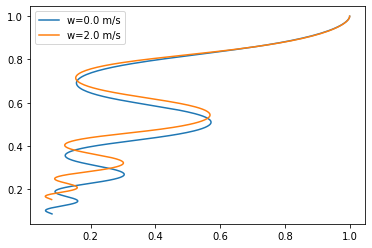

In [4]:
def get_2d_quad_lqr():
    mass = 0.1  # kg
    inertia = 0.001  # kg-m^2
    r = 0.05  # m, distance from center to propeller

    # Define linearized dynamics
    A = np.zeros((6, 6))
    A[:3, 3:] = np.eye(3)
    A[3, 2] = -0.981
    
    B = np.zeros((6, 2))
    B[4, :] = r / mass
    B[5, 0] = r / inertia
    B[5, 1] = -r / inertia
    
    # Define cost matrices
    Q = 1 * np.eye(6)
    R = 2 * np.eye(2)
    
    # Solve Ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
    
    return np.array(K)

dp = jnp.zeros(14)
dp = dp.at[12:].add(0.981 / 2.0)
dp = dp.at[:12].add(get_2d_quad_lqr().flatten())
ep = jnp.array([1.0, 1.0])

w1 = 0.0
w2 = 2.0
q1 = simulate(dp, w1 * ep, time_horizon=5.0)

q2 = simulate(dp, w2 * ep, time_horizon=5.0)

plt.plot(q1[:, 0], q1[:, 1], label=f"w={w1} m/s")
plt.plot(q2[:, 0], q2[:, 1], label=f"w={w2} m/s")
plt.legend()

## First-order optimization

Let's take a look at how well the baseline controller's performance changes as a function of wind speed.

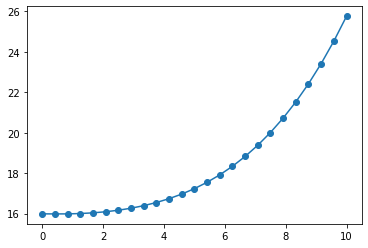

In [5]:
dp = jnp.zeros(14)
dp = dp.at[12:].add(0.981 / 2.0)
dp = dp.at[:12].add(get_2d_quad_lqr().flatten())
n_trials = 25
ep = jnp.linspace(0.0, 10.0, n_trials).reshape(n_trials, 1)

batched_cost = lambda exogenous: cost(dp, exogenous, time_horizon=5.0)
costs = jax.vmap(batched_cost)(ep)

plt.plot(ep[:, 0], costs, "o-")

A plot like this begs two questions. 1: How can we optimize our controller to work better at a given windspeed? 2: How can we optimize our controller to be *less sensitive* to the changes in wind speed.

Let's try to answer the first question here.

In [6]:
# Initialize our controller with a guess from LQR
dp = jnp.zeros(14)
dp = dp.at[12:].add(0.981 / 2.0)
dp = dp.at[:12].add(get_2d_quad_lqr().flatten())
# Save the initial guess for posterity
dp_0 = dp.clone()

# Also pick a wind-speed to operate in
ep = 4.0 * jnp.ones(2)

# Set up some details for a gradient-descent-based optimization
n_steps = 20
learning_rate = 1e-2

# Get the grad function
cost_fn = lambda design: cost(design, ep, time_horizon=5.0)
grad_fn = jax.grad(cost_fn)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.91s/it]


Text(0, 0.5, 'Cost')

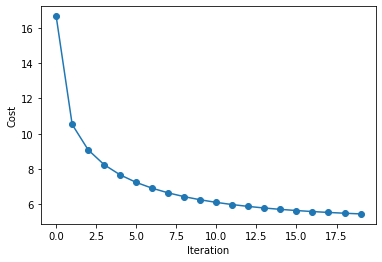

In [7]:
# Run gradient descent
costs = []
prog_bar = tqdm(range(n_steps))
for i in prog_bar:
    costs.append(cost_fn(dp))
    cost_grad = grad_fn(dp)
    dp = dp - learning_rate * cost_grad

plt.plot(costs, "o-")
plt.xlabel("Iteration")
plt.ylabel("Cost")

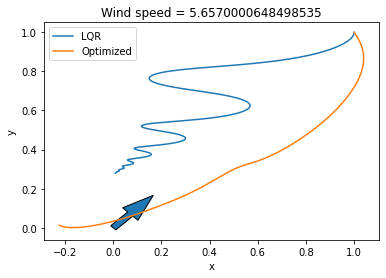

In [8]:
# Plot the improved controller vs the original
ep = 4.0 * jnp.ones(2)
q_0 = simulate(dp_0, ep, time_horizon=10.0)
q_opt = simulate(dp, ep, time_horizon=10.0)

plt.plot(q_0[:, 0], q_0[:, 1], label=f"LQR")
plt.plot(q_opt[:, 0], q_opt[:, 1], label=f"Optimized")
plt.title(f"Wind speed = {round(jnp.linalg.norm(ep), 3)}")
plt.xlabel("x")
plt.ylabel("y")
arrow = 0.1 * ep / jnp.linalg.norm(ep)
plt.arrow(0, 0, dx=arrow[0], dy=arrow[1], width=0.03)
plt.legend()

In [9]:
# Save a copy of the design parameters from earlier
dp_no_sens = dp.clone()

So the answer to our first question is yes! We can optimize the controller performance! The next question is how sensitive this solution is to changes in the wind speed

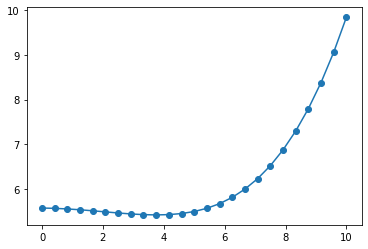

In [10]:
n_trials = 25
ep = jnp.linspace(0.0, 10.0, n_trials).reshape(n_trials, 1)
batched_cost = lambda exogenous: cost(dp, exogenous, time_horizon=5.0)
costs = jax.vmap(batched_cost)(ep)

plt.plot(ep[:, 0], costs, "o-")

What if we augment our cost to include the sensitivity to the wind disturbance?

In [16]:
def cost_plus_sensitivity(
    design_parameters,
    exogenous_parameters,
):
    """
    Simulates the performance of the system over the specified time horizon and
    returns the cost.
    
    The system is the 2D quadrotor, with state [px, pz, theta, vx, vz, theta_dot],
    control inputs [u_left, u_right], and exogenous parameter giving the wind speed
    in the -x direction [w].
    
    We use simplified flat plate aerodynamics as in
    http://underactuated.mit.edu/trajopt.html#perching
    
    args:
        design_parameters: (14,) array giving linear feedback control gains,
                           where the first 6 values are the first row of K, the next 6
                           are the second row, and the last 2 values are u_0 (defined so
                           that u = -K @ x + u_0)
        exogenous_parameters: (2,) array of wind speeds.
    returns:
        The cost
    """
    # Parameters
    time_horizon=5.0
    time_step=1e-2
    sensitivity_regularization=1e1

    # Simulate the system to get the state, along with its gradient wrt exogenous parameters
    c, grad_e_c = jax.value_and_grad(cost, 1)(design_parameters, exogenous_parameters, time_horizon, time_step)
    
    # Augment the cost
    c = c + sensitivity_regularization * jnp.linalg.norm(grad_e_c)
    
    return c

cost = 5.708920001983643, grad norm = 7.580077171325684: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:51<00:00, 17.58s/it]


Text(0, 0.5, 'Cost')

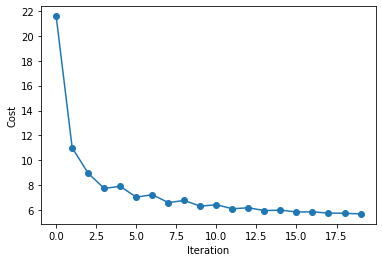

In [18]:
# Restart from original solution
dp = dp_0.clone()
# Run gradient descent with a single wind speed
ep = 4.0 * jnp.ones(2)

# Set GD speed
learning_rate = 1e-2

cost_fn = lambda dp: cost_plus_sensitivity(dp, ep)
cost_grad_fn = jax.grad(cost_fn)

costs = []
prog_bar = tqdm(range(n_steps))
for i in prog_bar:
    costs.append(cost_fn(dp))
    cost_grad = cost_grad_fn(dp)
    prog_bar.set_description(f"cost = {costs[-1]}, grad norm = {jnp.linalg.norm(cost_grad)}")
    dp = dp - learning_rate * cost_grad

plt.plot(costs, "o-")
plt.xlabel("Iteration")
plt.ylabel("Cost")

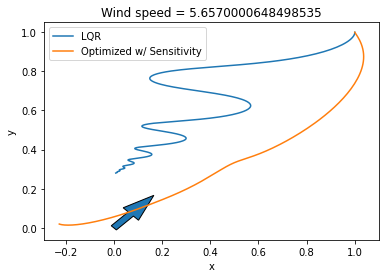

In [19]:
# Plot the improved controller vs the original
ep = 4.0 * jnp.ones(2)
q_0 = simulate(dp_0, ep, time_horizon=10.0)
q_opt = simulate(dp, ep, time_horizon=10.0)

plt.plot(q_0[:, 0], q_0[:, 1], label=f"LQR")
plt.plot(q_opt[:, 0], q_opt[:, 1], label=f"Optimized w/ Sensitivity")
plt.title(f"Wind speed = {round(jnp.linalg.norm(ep), 3)}")
plt.xlabel("x")
plt.ylabel("y")
arrow = 0.1 * ep / jnp.linalg.norm(ep)
plt.arrow(0, 0, dx=arrow[0], dy=arrow[1], width=0.03)
plt.legend()

Now, how much does this regularization change the cost landscape wrt the wind speed?

In [38]:
n_trials = 25
ep = jnp.stack((jnp.linspace(0.0, 10.0, n_trials), jnp.linspace(0.0, 10.0, n_trials))).T

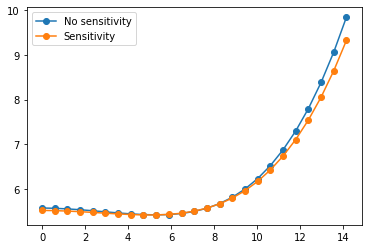

In [39]:
batched_cost = lambda exogenous: cost(dp_no_sens, exogenous)
costs_orig = jax.vmap(batched_cost)(ep)
batched_cost = lambda exogenous: cost(dp, exogenous)
costs_sens = jax.vmap(batched_cost)(ep)

plt.plot(jnp.linalg.norm(ep, axis=1), costs_orig, "o-")
plt.plot(jnp.linalg.norm(ep, axis=1), costs_sens, "o-")
plt.legend(["No sensitivity", "Sensitivity"])